# Introduction to text embeddings on S&P 500 news

objectives# 📌 Objectives

By the end of this notebook, students will be able to:

1. **Retrieve Financial News:**
   - Use the `yfinance` library to gather news headlines for all companies in the S&P 500 index.

2. **Clean and Structure Financial Text Data:**
   - Extract and organize relevant metadata (e.g., ticker, title, summary, publication date, URL) into a structured pandas DataFrame.

3. **Generate Text Embeddings:**
   - Apply a pre-trained sentence transformer model (`all-MiniLM-L6-v2`) to convert news headlines and summaries into numerical embeddings.

4. **Apply Clustering Techniques:**
   - Use K-Means clustering to identify groups of similar news articles based on semantic content.

5. **Determine Optimal Number of Clusters:**
   - Evaluate clustering quality using silhouette scores to find the best number of clusters.

6. **Visualize High-Dimensional Embeddings:**
   - Reduce the embedding space using PCA and visualize clusters in two dimensions.

7. **Interpret Cluster Themes:**
   - Analyze representative news


## Install and Import important librairies

In [ ]:
%pip install pandas
%pip install yfinance
%pip install lxml
%pip install -U sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 470.2/470.2 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 99.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 69.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 39.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [ ]:
from sentence_transformers import SentenceTransformer
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
import pandas as pd
from sklearn.metrics import silhouette_score
import yfinance as yf

## Get the list of stocks in the S&P 500

In [ ]:
# Read and print the stock tickers that make up S&P500
df_tickers = pd.read_html(
    'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

display(df_tickers.head())

Symbol             Security             GICS Sector  \
0    MMM                   3M             Industrials   
1    AOS          A. O. Smith             Industrials   
2    ABT  Abbott Laboratories             Health Care   
3   ABBV               AbbVie             Health Care   
4    ACN            Accenture  Information Technology   

                GICS Sub-Industry    Headquarters Location  Date added  \
0        Industrial Conglomerates    Saint Paul, Minnesota  1957-03-04   
1               Building Products     Milwaukee, Wisconsin  2017-07-26   
2           Health Care Equipment  North Chicago, Illinois  1957-03-04   
3                   Biotechnology  North Chicago, Illinois  2012-12-31   
4  IT Consulting & Other Services          Dublin, Ireland  2011-07-06   

       CIK      Founded  
0    66740         1902  
1    91142         1916  
2     1800         1888  
3  1551152  2013 (1888)  
4  1467373         1989

In [ ]:
ticker_list = df_tickers['Symbol'].tolist()

## Get the news of all 500 stocks in the S&P 500 Index
Use the yfinance library to retrieve the news of all 500 stocks in the index.
https://ranaroussi.github.io/yfinance/reference/yfinance.stock.html

### Get the news in a dictionary

In [16]:
# Create a dictionary where the keys are the symbols (tickers) of each 500 stocks
# and the value is the output news from the yfinance library
from tqdm import tqdm

# Clean up tickers for Yahoo Finance (replace '.' with '-')
ticker_list = [ticker.replace('.', '-') for ticker in ticker_list]

# Create dictionary with news per ticker
news_dict = {}

for ticker in tqdm(ticker_list, desc="Fetching news"):
    try:
        ticker_obj = yf.Ticker(ticker)
        news = ticker_obj.news  # list of dictionaries (each is one article)
        news_dict[ticker] = news
    except Exception as e:
        print(f"Failed for {ticker}: {e}")
        news_dict[ticker] = None

Fetching news: 100%|██████████| 503/503 [01:18<00:00,  6.38it/s]


### Structure the news into a pandas dataframe

Your final dataframe should have the following columns:
- TICKER
- TITLE (of the news)
- SUMMARY (of the news)
- PUBLICATION_DATE (of the news)
- URL (of the news)

Note: all of those fields are provided in the yfinance news component. Refer to the library documentation.

In [17]:
print(news_dict)

{'MMM': [{'id': '2f475c52-e043-3340-9129-7f18b3fdb18d', 'content': {'id': '2f475c52-e043-3340-9129-7f18b3fdb18d', 'contentType': 'STORY', 'title': '3M Company (MMM): “I Was Surprised” By The Organic Growth Rate, Says Jim Cramer', 'description': '', 'summary': 'We recently published 12 Stocks Jim Cramer Talked About. 3M Company (NYSE:MMM) is one of the stocks Jim Cramer recently discussed. 3M Company (NYSE:MMM) is one of the largest industrial conglomerates in the world. Its shares have gained 16.7% year-to-date as part of a bullish run in industrial stocks that Cramer has commented on several […]', 'pubDate': '2025-07-24T09:03:00Z', 'displayTime': '2025-07-24T09:03:00Z', 'isHosted': True, 'bypassModal': False, 'previewUrl': None, 'thumbnail': {'originalUrl': 'https://media.zenfs.com/en/insidermonkey.com/093e1a4edd0e304bc17c1f522a735210', 'originalWidth': 1000, 'originalHeight': 667, 'caption': '3M Company (MMM): "I Was Surprised" By The Organic Growth Rate, Says Jim Cramer', 'resolutio

In [18]:
# YOUR CODE HERE
# USE AS MANY CELLS AS YOU NEED
# MAKE SURE TO DISPLAY INTERMEDIARY RESULS

print("\nStructuring news into a DataFrame...")
all_news_data = []
for ticker, news_articles in news_dict.items():
    if news_articles:
        for article in news_articles:
            # Access the 'content' dictionary first
            content = article.get('content', {}) # Use .get() to avoid KeyError if 'content' is missing

            # Now access the fields from the 'content' dictionary
            title = content.get('title', 'N/A')
            summary = content.get('summary', 'N/A')

            publication_date_timestamp = article.get('providerPublishTime', None)
            if publication_date_timestamp is None:
                pub_date_str = content.get('pubDate', None)
                if pub_date_str:
                    try:
                        publication_date = pd.to_datetime(pub_date_str)
                    except ValueError:
                        publication_date = pd.NaT
                else:
                    publication_date = pd.NaT
            else:
                publication_date = pd.to_datetime(publication_date_timestamp, unit='s')

            # The URL is often directly accessible via 'link' at the article level
            url = article.get('link', 'N/A')
            # Or from 'canonicalUrl' or 'clickThroughUrl' within 'content' if 'link' isn't direct
            if url == 'N/A':
                canonical_url_info = content.get('canonicalUrl', {})
                url = canonical_url_info.get('url', 'N/A')


            all_news_data.append({
                'TICKER': ticker,
                'TITLE': title,
                'SUMMARY': summary,
                'PUBLICATION_DATE': publication_date,
                'URL': url
            })

df_news = pd.DataFrame(all_news_data)
print("\nNews DataFrame Head (before filtering for one news per company):")
print(df_news.head())
print(f"Total news articles fetched: {len(df_news)}")





Structuring news into a DataFrame...

News DataFrame Head (before filtering for one news per company):
  TICKER                                              TITLE  \
0    MMM  3M Company (MMM): “I Was Surprised” By The Org...   
1    MMM  Zacks Industry Outlook Highlights Honeywell, 3...   
2    MMM                 Stock Market News for Jul 21, 2025   
3    MMM  3M Co (MMM) Q2 2025 Earnings Call Highlights: ...   
4    MMM  MMM Q1 Deep Dive: Tariffs Loom Over Stable Ope...   

                                             SUMMARY  \
0  We recently published 12 Stocks Jim Cramer Tal...   
1  HON, MMM, CSL, and FSS are well-positioned to ...   
2  U.S. stock markets closed mostly lower n Frida...   
3  3M Co (MMM) reports a 12% increase in adjusted...   
4  Industrial conglomerate 3M (NYSE:MMM) reported...   

           PUBLICATION_DATE                                                URL  
0 2025-07-24 09:03:00+00:00  https://finance.yahoo.com/news/3m-company-mmm-...  
1 2025-07-21 09:45

## Exploring text embeddings

- Use the open-source model: 'sentence-transformers/all-MiniLM-L6-v2' to create embeddings on the news title and summary
- Add a column to your news dataframe called EMBEDDED_TEXT using ONLY the TITLE of the news
- Add a column to your news dataframe called EMBEDDINGS, which contains the embedding of EMBEDDED_TEXT


In [19]:
# YOUR CODE HERE
# USE AS MANY CELLS AS YOU NEED
# MAKE SURE TO DISPLAY INTERMEDIARY RESULS


print("\nCreating text embeddings...")
model_name = 'sentence-transformers/all-MiniLM-L6-v2'
model = SentenceTransformer(model_name)

# Create EMBEDDED_TEXT using ONLY the TITLE of the news
df_news['EMBEDDED_TEXT'] = df_news['TITLE']

# Create EMBEDDINGS column
# Check for empty or NaN titles before encoding
valid_titles = df_news['EMBEDDED_TEXT'].dropna().tolist()
if valid_titles:
    embeddings = model.encode(valid_titles, show_progress_bar=True)
    # Map embeddings back to the DataFrame
    # Create a Series with an index matching the valid_titles
    embedding_series = pd.Series(list(embeddings), index=df_news['EMBEDDED_TEXT'].dropna().index)
    df_news['EMBEDDINGS'] = embedding_series
else:
    print("No valid titles found to create embeddings.")
    df_news['EMBEDDINGS'] = None # Assign None or an empty list if no valid titles

# Drop rows where EMBEDDINGS could not be created (e.g., if title was NaN)
df_news.dropna(subset=['EMBEDDINGS'], inplace=True)

print("\nNews DataFrame Head with EMBEDDED_TEXT and EMBEDDINGS:")
print(df_news.head())
print(f"Number of news articles with embeddings: {len(df_news)}")




Creating text embeddings...


Batches:   0%|          | 0/152 [00:00<?, ?it/s]


News DataFrame Head with EMBEDDED_TEXT and EMBEDDINGS:
  TICKER                                              TITLE  \
0    MMM  3M Company (MMM): “I Was Surprised” By The Org...   
1    MMM  Zacks Industry Outlook Highlights Honeywell, 3...   
2    MMM                 Stock Market News for Jul 21, 2025   
3    MMM  3M Co (MMM) Q2 2025 Earnings Call Highlights: ...   
4    MMM  MMM Q1 Deep Dive: Tariffs Loom Over Stable Ope...   

                                             SUMMARY  \
0  We recently published 12 Stocks Jim Cramer Tal...   
1  HON, MMM, CSL, and FSS are well-positioned to ...   
2  U.S. stock markets closed mostly lower n Frida...   
3  3M Co (MMM) reports a 12% increase in adjusted...   
4  Industrial conglomerate 3M (NYSE:MMM) reported...   

           PUBLICATION_DATE  \
0 2025-07-24 09:03:00+00:00   
1 2025-07-21 09:45:00+00:00   
2 2025-07-21 08:22:00+00:00   
3 2025-07-19 07:05:47+00:00   
4 2025-07-19 05:30:58+00:00   

                                         

## Using K-means clustering on news embeddings
to simplify, keep only one news for each company (ticker), you should have 500 rows in your news dataframe

In [20]:
# YOUR CODE HERE
# USE AS MANY CELLS AS YOU NEED
# MAKE SURE TO DISPLAY INTERMEDIARY RESULS

# To simplify, keep only one news for each company (ticker)
df_news_unique = df_news.sort_values(by=['TICKER', 'PUBLICATION_DATE'], ascending=[True, False])
df_news_unique = df_news_unique.drop_duplicates(subset=['TICKER'], keep='first')
print(f"\nNews DataFrame Head (after keeping one news per company):")
print(df_news_unique.head())
print(f"Number of unique company news articles: {len(df_news_unique)}")



News DataFrame Head (after keeping one news per company):
    TICKER                                              TITLE  \
90       A  Agilent Technologies' Q3 2025 Earnings: What t...   
382   AAPL  Dow Jones Futures Loom As Trump-EU Trade Deal ...   
30    ABBV  The Smartest Dividend Stocks to Buy With $350 ...   
110   ABNB  Airbnb's Cash Cow Can Thrive Despite Its Chall...   
20     ABT  Declining Stock and Solid Fundamentals: Is The...   

                                               SUMMARY  \
90   Agilent Technologies is expected to release it...   
382  A U.S-EU trade deal avoids a Trump tariff hike...   
30   These stocks offer juicy dividends, solid grow...   
110  The short-term rental king is a major player i...   
20   It is hard to get excited after looking at Abb...   

             PUBLICATION_DATE  \
90  2025-07-24 12:27:49+00:00   
382 2025-07-27 18:07:58+00:00   
30  2025-07-26 08:50:00+00:00   
110 2025-07-26 13:09:00+00:00   
20  2025-07-27 11:02:42+00:00   

  

In [21]:
# Add a check to see if we have exactly 500 rows
num_unique_news = len(df_news_unique)
print(f"Number of unique company news articles: {num_unique_news}")

if num_unique_news < 500:
    print(f"\nWarning: Only {num_unique_news} unique news articles were retrieved, instead of the expected 500.")
    print("This usually happens because yfinance did not return news for all S&P 500 tickers.")

elif num_unique_news > 500:
    print(f"\nWarning: Retrieved {num_unique_news} news articles, which is more than 500 unique companies.")
    print("This might indicate an issue with the initial ticker list or news parsing.")


Number of unique company news articles: 484

This usually happens because yfinance did not return news for all S&P 500 tickers.


### Identify the number of clusters using the silhouette score

- Using a for loop, do the clustering with different k values (number of clusters), test 1 to 6 clusters
- Compute the silhouette score for every k value
- Plot the silhouette score for different k values

In [23]:

# Convert embeddings to a list of lists/arrays for clustering
# Ensure all embeddings are not None and are arrays/lists

import numpy as np

news_embeddings = np.array([emb for emb in df_news_unique['EMBEDDINGS'].tolist() if emb is not None])

if news_embeddings.size == 0:
    print("No embeddings available for clustering. Exiting.")
else:
    # Using K-means clustering on news embeddings
    print("\nPerforming K-means clustering and identifying best k using silhouette score...")

    # Identify the number of clusters using the silhouette score
    k_values = range(2, 7)  # Test 2 to 6 clusters (silhouette score needs at least 2 clusters)
    silhouette_scores = []

    for k in tqdm(k_values, desc="Testing K for silhouette score"):
        if len(news_embeddings) >= k: # Ensure there are enough samples for k clusters
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10) # n_init for robust centroids
            cluster_labels = kmeans.fit_predict(news_embeddings)
            score = silhouette_score(news_embeddings, cluster_labels)
            silhouette_scores.append(score)
            print(f"k={k}, Silhouette Score: {score}")
        else:
            silhouette_scores.append(np.nan) # Append NaN if not enough samples
            print(f"Not enough samples ({len(news_embeddings)}) for k={k} clusters.")


Performing K-means clustering and identifying best k using silhouette score...


Testing K for silhouette score:  20%|██        | 1/5 [00:00<00:00,  5.23it/s]

k=2, Silhouette Score: 0.04237614944577217


Testing K for silhouette score:  40%|████      | 2/5 [00:00<00:00,  7.26it/s]

k=3, Silhouette Score: 0.04767987132072449


Testing K for silhouette score:  60%|██████    | 3/5 [00:00<00:00,  7.90it/s]

k=4, Silhouette Score: 0.04715204983949661


Testing K for silhouette score:  80%|████████  | 4/5 [00:00<00:00,  6.92it/s]

k=5, Silhouette Score: 0.05620711296796799


Testing K for silhouette score: 100%|██████████| 5/5 [00:00<00:00,  6.23it/s]

k=6, Silhouette Score: 0.06194039061665535


#### Try different values of k and compute silhouette scores


In [ ]:
#Tests displayed above

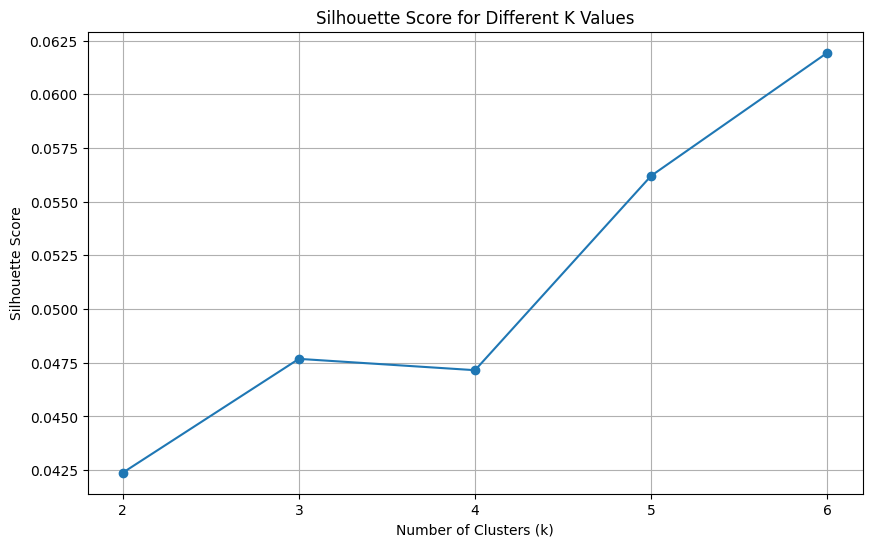

In [24]:
# YOUR CODE HERE
# USE AS MANY CELLS AS YOU NEED
# MAKE SURE TO DISPLAY INTERMEDIARY RESULS
# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, marker='o')
plt.title('Silhouette Score for Different K Values')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(list(k_values))
plt.grid(True)
plt.show()

#### Identify the Best k

In [25]:
# YOUR CODE HERE
# USE AS MANY CELLS AS YOU NEED
# MAKE SURE TO DISPLAY INTERMEDIARY RESULS

# Identify the Best k (highest silhouette score)
# Filter out NaNs before finding the max
valid_silhouette_scores = [(score, k) for score, k in zip(silhouette_scores, k_values) if not np.isnan(score)]
if valid_silhouette_scores:
  best_k = valid_silhouette_scores[np.argmax([s[0] for s in valid_silhouette_scores])][1]
  print(f"\nBest K identified by Silhouette Score: {best_k}")
else:
  best_k = 3 # Default to 3 if no valid scores
  print(f"\nCould not determine best K from silhouette scores, defaulting to k={best_k}.")




Best K identified by Silhouette Score: 6


#### Cluster the embeddings using 3 clusters (k=3)

In [27]:
# YOUR CODE HERE
# USE AS MANY CELLS AS YOU NEED
# MAKE SURE TO DISPLAY INTERMEDIARY RESULS
# Cluster the embeddings using 3 clusters (k=3)
final_k = 3
print(f"\nClustering embeddings using K={final_k}...")
kmeans_final = KMeans(n_clusters=final_k, random_state=42, n_init=10)
cluster_labels_final = kmeans_final.fit_predict(news_embeddings)

# Add the kmeans cluster label to your news dataframe
# Make sure the index aligns correctly after dropping NaNs
df_news_unique['CLUSTER_LABEL'] = pd.Series(cluster_labels_final, index=df_news_unique.index)
print("\nNews DataFrame Head with CLUSTER_LABEL:")
print(df_news_unique.head())


Clustering embeddings using K=3...

News DataFrame Head with CLUSTER_LABEL:
    TICKER                                              TITLE  \
90       A  Agilent Technologies' Q3 2025 Earnings: What t...   
382   AAPL  Dow Jones Futures Loom As Trump-EU Trade Deal ...   
30    ABBV  The Smartest Dividend Stocks to Buy With $350 ...   
110   ABNB  Airbnb's Cash Cow Can Thrive Despite Its Chall...   
20     ABT  Declining Stock and Solid Fundamentals: Is The...   

                                               SUMMARY  \
90   Agilent Technologies is expected to release it...   
382  A U.S-EU trade deal avoids a Trump tariff hike...   
30   These stocks offer juicy dividends, solid grow...   
110  The short-term rental king is a major player i...   
20   It is hard to get excited after looking at Abb...   

             PUBLICATION_DATE  \
90  2025-07-24 12:27:49+00:00   
382 2025-07-27 18:07:58+00:00   
30  2025-07-26 08:50:00+00:00   
110 2025-07-26 13:09:00+00:00   
20  2025-07-27 11:

### Visualize the 2 first PCA Components of your embeddings


Visualizing the first 2 PCA Components...


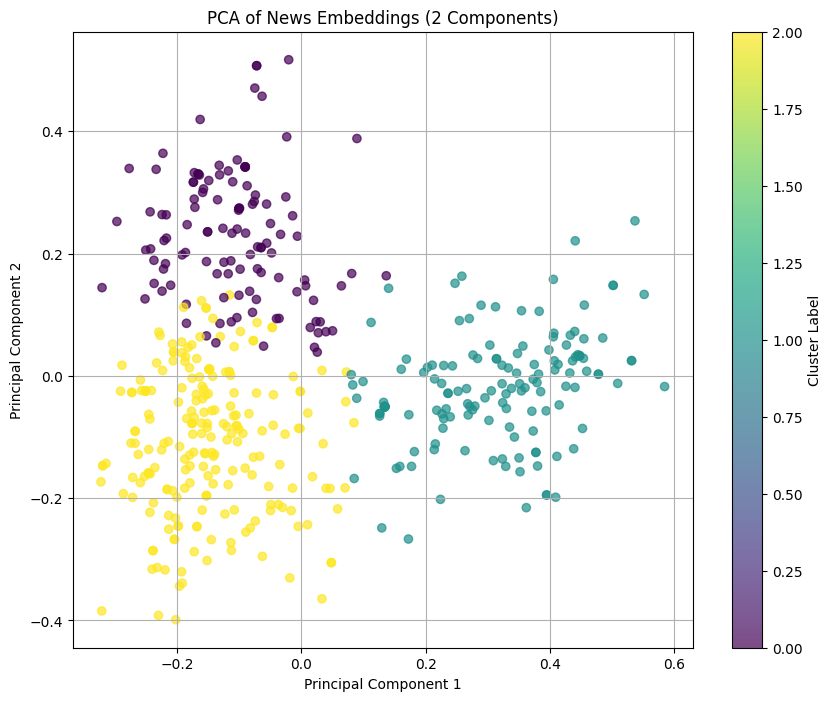

In [28]:
# YOUR CODE HERE
# USE AS MANY CELLS AS YOU NEED
# MAKE SURE TO DISPLAY INTERMEDIARY RESULS

print("\nVisualizing the first 2 PCA Components...")
pca = PCA(n_components=2)
pca_components = pca.fit_transform(news_embeddings)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(pca_components[:, 0], pca_components[:, 1], c=df_news_unique['CLUSTER_LABEL'], cmap='viridis', alpha=0.7)
plt.title('PCA of News Embeddings (2 Components)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter, label='Cluster Label')
plt.grid(True)
plt.show()


#### Analyze the content of each cluster
- Add the kmeans cluster label to your news dataframe
- Print the content of each cluster and analyze it

In [31]:
# YOUR CODE HERE
# USE AS MANY CELLS AS YOU NEED
# MAKE SURE TO DISPLAY INTERMEDIARY RESULS
# Add the kmeans cluster label to your news dataframe

print("\nAnalyzing the content of each cluster:")
for cluster_id in sorted(df_news_unique['CLUSTER_LABEL'].unique()):
  print(f"\n--- Cluster {cluster_id} ---")
  cluster_news = df_news_unique[df_news_unique['CLUSTER_LABEL'] == cluster_id]
  print(f"Number of articles in Cluster {cluster_id}: {len(cluster_news)}")
  # Print a few example titles and summaries from each cluster
  for i, row in cluster_news.head(5).iterrows(): # Display top 5 articles per cluster
    print(f"  TICKER: {row['TICKER']}")
    print(f"  TITLE: {row['TITLE']}")
    print(f"  SUMMARY: {row['SUMMARY'][:150]}...") # Truncate summary for readability
    print("-" * 30)


Analyzing the content of each cluster:

--- Cluster 0 ---
Number of articles in Cluster 0: 116
  TICKER: ABNB
  TITLE: Airbnb's Cash Cow Can Thrive Despite Its Challenges
  SUMMARY: The short-term rental king is a major player in a trillion-dollar market....
------------------------------
  TICKER: ACGL
  TITLE: Arch Capital Group (ACGL) Expands Health Product Suite With New Supplement Offerings
  SUMMARY: Arch Capital Group (ACGL) recently introduced a suite of individual supplemental health products via its Accident & Health business unit, designed to ...
------------------------------
  TICKER: ADSK
  TITLE: Loop Capital Initiates Coverage on Autodesk, Inc. (ADSK) with ‘Hold’ Rating
  SUMMARY: By earning a spot on Ethisphere’s 2025 list of the World’s Most Ethical Companies and attracting significant hedge fund interest, Autodesk, Inc. (NASD...
------------------------------
  TICKER: ALGN
  TITLE: Align Technology, Inc. (ALGN): A Bull Case Theory
  SUMMARY: We came across a bullis



## Question Section

Take time to reflect on what you've implemented and observed. Answer the following questions in a separate markdown cell or notebook file:

---

### Technical Understanding

#### 1️⃣ How might the choice of embedding model (e.g., MiniLM vs. a larger transformer) affect your clustering results and interpretation?

The choice of embedding model impacts clustering by affecting the quality and richness of semantic representation.

    MiniLM (smaller): Faster, less resource-intensive, but may miss subtle semantic nuances, leading to less precise embeddings and potentially less coherent clusters.

    Larger Transformers: Slower, resource-intensive, but provide more nuanced and contextually rich embeddings. This can result in higher silhouette scores, more coherent, and better-separated clusters, leading to more meaningful interpretation.

Ultimately, it's a trade-off between computational cost/speed and embedding accuracy/cluster quality.

---

#### 2️⃣ What would be the differences in embeddings if you used only the TITLE, only the SUMMARY, or the combination of both? How could you empirically test this?

* Only TITLE:
    * Embeddings: Will be concise and capture the core essence or main topic. Titles are often designed to be attention-grabbing and convey the primary subject succinctly.
    * Clustering: Likely to group articles based on very high-level themes. Clusters might be broad (e.g., "Company X Earnings," "Tech Innovation," "Economic Policy"). Similar nuances might be lost, as short titles lack detailed context.
* Only SUMMARY:
    * Embeddings: Will be richer than titles, providing more context and detail. Summaries aim to encapsulate the main points and key information of an article.
    * Clustering: Will likely produce more granular and semantically coherent clusters than titles alone. It can distinguish between sub-topics within a broader theme. For example, "Company X Earnings" might split into "Company X Earnings Beat Expectations" and "Company X Earnings Miss."

* Combination of both (TITLE + SUMMARY):
  * Embeddings: This approach aims to leverage the best of both worlds. The title provides a strong, concise signal of the primary topic, while the summary adds the necessary detail and context. Concatenating them (e.g., "TITLE: " + title + " SUMMARY: " + summary) allows the model to process both as a single input.
  * Clustering: Often yields the most robust and meaningful clusters. The embeddings benefit from both the concise topic signal and the richer contextual information, potentially leading to highly cohesive and well-separated groups that capture a good balance of breadth and depth in topics.


To Test empirically:

Create three new columns in the df_news_unique DataFrame:
* 'EMBED_INPUT_TITLE' (contains only df_news_unique['TITLE'])
* 'EMBED_INPUT_SUMMARY' (contains only df_news_unique['SUMMARY'])
* 'EMBED_INPUT_COMBINED' (contains df_news_unique['TITLE'] + " " + df_news_unique['SUMMARY'] or a formatted string like "TITLE: " + title + ". SUMMARY: " + summary)


Loop through each input type: For input_col in ['EMBED_INPUT_TITLE', 'EMBED_INPUT_SUMMARY', 'EMBED_INPUT_COMBINED']:
1. Generate Embeddings
2. Determine Best k (Silhouette Score)
3. Perform Clustering
4. Visualize PCA Components
5. Qualitative Analysis
6. Comparison and interpretation



---

#### 3️⃣ In what situations would using a different dimensionality reduction method (e.g., t-SNE, UMAP) be preferable over PCA for visualization of embeddings?

We can use t-SNE or UMAP instead of PCA for visualization when:
1. Revealing Clusters: You want to see natural groupings and local relationships in the data.
2. Non-linear Data: Your data has complex, curved underlying structures (common with embeddings).
3. No Interpretable Axes Needed: You care about seeing groups, not interpreting what each axis means.
4. Complex Data: PCA creates a messy "blob" with high-dimensional data like embeddings.


---

### Data Analysis and Interpretation

#### 4️⃣ Based on your cluster analysis, identify at least two potential challenges you faced in interpreting the clusters and propose strategies to address them.

Challenge 1: Lack of Clear Thematic Separation / Mixed Content Within Clusters

Observation from the output:
* Cluster 0: Contains a mix of news about "cash cow" (Airbnb), "product expansion" (Arch Capital), "analyst ratings" (Autodesk), "bull case" (Align Technology), and "Street calls" (AMD). These seem somewhat disparate.
* Cluster 2: Similarly broad, with "trade deals/robotaxis" (Apple), "dividend stocks" (AbbVie, Accenture), "stock performance analysis" (Abbott), and "AI stocks" (Adobe).
This suggests that while the clusters group articles, the themes within each cluster might still be quite diverse, making it hard to assign a single, concise label to the cluster.
Strategies to Address:
1. Refine Embedding Input:
    * Test "TITLE + SUMMARY": As discussed previously, using the concatenation of title and summary might provide richer context for embeddings, allowing the model to distinguish more nuanced themes. Empirically test this to see if it improves separation.
    * Consider a Stronger Embedding Model: If MiniLM is too compact for the required semantic detail, experiment with a slightly larger Sentence Transformer model (e.g., all-mpnet-base-v2). While slower, it might capture finer distinctions, leading to more coherent clusters.
2. Increase the Number of Clusters (K):
    * The current analysis used K=3. The Silhouette Score analysis provided insight into the "best K." If the silhouette score suggests a higher k (e.g., 4 or 5), try clustering with that k. More clusters might allow for a finer-grained categorization of news, reducing the diversity within each cluster.

Challenge 2: Difficulty in Assigning a Representative Label to Each Cluster

Because the content within the clusters is somewhat mixed, it's hard to come up with a single, and descriptive label for "Cluster 0," "Cluster 1," or "Cluster 2" that accurately captures all or most of the articles within it. For example, "Cluster 0" contains financial analysis, product news, and analyst coverage.
Strategies to Address:
1. Extract Keywords/Keyphrases per Cluster:
    * TF-IDF on Cluster Text: For each cluster, concatenate all the titles and summaries. Then, compute TF-IDF (Term Frequency-Inverse Document Frequency) scores for terms within that combined text. High TF-IDF words are more unique and representative of that specific cluster.
2. Representative Article Selection:
    * Identify the article(s) closest to the cluster centroid (the mean embedding of all articles in that cluster). These are the most "typical" articles and their titles/summaries can often suggest a good cluster label.
    * Manually review several articles from the core of each cluster (e.g., 5-10 articles, not just 5) to form a more comprehensive understanding of the common themes.


---

#### 5️⃣ Did you observe any outliers in your 2D visualization? How would you identify and handle these outliers in a production pipeline?

I see two:

Top-Left: There are a few purple/dark points very high up on Principal Component 2 (around 0.5) and to the left (around -0.2 to -0.3 on PC1), appearing somewhat isolated from the main purple cluster below them.

Bottom-Right: Similarly, a couple of greenish/teal points are quite low on Principal Component 2 (around -0.4) and to the right (around 0.4 on PC1), appearing distant from the main teal cluster.

Identification:

    Visual: Look for isolated points far from main clusters in 2D plots (like your PCA visualization).

    Distance-Based: Points far from cluster centroids or k-nearest neighbors (e.g., using Euclidean distance, LOF).

    Density-Based: Points in low-density regions that don't belong to any cluster (e.g., DBSCAN's "noise").

    Statistical/Model-Based: Algorithms like Isolation Forest or One-Class SVM trained to flag anomalies.

Handling:

    Removal: Delete outliers if they're considered noise or errors that distort analysis.

    Separate Cluster: Assign outliers to a distinct "Anomaly" cluster for separate analysis if they represent rare, important events.

    Transformation: Use robust scaling (e.g., RobustScaler) to lessen their impact on clustering.

    Investigation: Manually review outliers to understand their nature (e.g., data errors, unique events).

    Robust Algorithms: Employ clustering methods inherently resistant to outliers (e.g., DBSCAN).



---

#### 6️⃣ If you could assign a 'label' or 'theme' to each cluster you obtained, what would they be? How confident are you in these assignments, and what could you do to validate them systematically?

Potential Cluster Labels/Themes:
* Cluster 0: "General Corporate/Analyst Activity"
    * Reasoning: This cluster seems to encompass news related to a company's general business operations, strategic moves, product offerings, and particularly, coverage by financial analysts (initiating coverage, "bull cases," "Street calls"). It's less about specific financial results and more about broader corporate or market commentary.
* Cluster 1: "Upcoming Earnings/Financial Expectations"
    * Reasoning: This cluster strongly focuses on company earnings reports, financial outlooks, and analyst expectations leading up to these reports. The repeated phrases "Q3/Q4 Earnings," "What to Expect," "Report Q4 Earnings," and "Analysts' Insights" are strong indicators.
* Cluster 2: "Broader Market Trends & Investment Strategies"
    * Reasoning: This cluster appears to cover broader market discussions, investment advice (like "Smartest Dividend Stocks," "Best Bargain AI Stocks"), and general analysis of stock performance and market events, rather than company-specific operational or earnings news. It mentions "Dow Jones Futures," "Trade Deal," and general stock performance observations.

My confidence is moderate for Cluster 1, this is my first exersice but I’m seeing very consistent and specific keywords related to earnings reports.
For Cluster 0 and 2, my confidence is low, due to teh fact that the provided snippets suggest these clusters might still contain a slightly wider variety of sub-themes.

I think this can bu systematically review by Quantitative Validation (Internal Metrics)
---

### Critical Thinking

#### 7️⃣ If news sentiment was incorporated into the analysis, how might this influence the clustering structure and interpretation of the clusters in a financial analysis context?

Incorporating news sentiment (positive, negative, neutral) into the financial news clustering analysis would profoundly influence both the clustering structure and its interpretation:

Clustering Structure: Create sentiment-driven sub-clusters (e.g., "Positive Earnings" vs. "Negative Earnings"), leading to clearer separation for sentiment-sensitive topics.

Interpretation: Enhance actionability (direct investment signals, risk flags), provide nuanced market understanding (how news is perceived), and offer granular strategic insights (competitor sentiment, product performance).

---

#### 8️⃣ Discuss the limitations of using k-means clustering for news embeddings. What alternative clustering methods could address these limitations, and under what conditions would you prefer them?

K-means clustering, despite its simplicity and speed, has inherent limitations when applied to the complex world of news embeddings. It fundamentally assumes that clusters are spherical and of similar size, which rarely holds true for diverse news topics that can form arbitrary shapes or have varying densities. A significant drawback is its requirement to specify the number of clusters (k) beforehand; while metrics like the Silhouette Score offer guidance, pinpointing the true k for intricate news data remains challenging. Furthermore, K-means is susceptible to outliers, as these can pull cluster centroids and distort the overall grouping. Its reliance on initial centroid placement can also lead to different results across runs, though multiple initializations help. Finally, K-means forces each article into a single, rigid cluster, which can misrepresent news that genuinely touches upon multiple themes.

To overcome these limitations, several alternative clustering methods offer more flexibility and robustness. DBSCAN is a valuable alternative, as it excels at discovering clusters of arbitrary shapes and can automatically identify "noise" points or outliers. This makes it ideal when news topics might not conform to neat, spherical boundaries or when identifying anomalous news articles is important, and when the exact number of topics is unknown.

Hierarchical Clustering, particularly agglomerative methods, builds a nested structure of clusters, allowing you to visually explore the relationships between broader themes and their sub-topics through a dendrogram. It doesn't require a pre-defined k, offering the flexibility to choose the level of granularity after the clustering process. This method is particularly useful for understanding how general news categories break down into more specific ones, especially for datasets of moderate size.

---

#### 9️⃣ How could the approach in this notebook be extended to analyze the potential impact of news clusters on stock price movements over time? Sketch a high-level pipeline you would implement to test this.

To analyze the potential impact of news clusters on stock price movements, it would be needed to extend the current notebook's approach by integrating time-series stock data and sentiment analysis, followed by a robust statistical or machine learning framework.

Here's a high-level pipeline:

1. Data Acquisition and Preprocessing:

    Expanded News Data: Continue fetching news for S&P 500 companies, but importantly.

    Stock Price Data: For each ticker, retrieve historical stock price data (e.g., daily open, high, low, close, volume) for the same period as the news, or ideally, a period extending well past the news publication dates to observe subsequent movements.

    Sentiment Analysis (News): Integrate a robust sentiment analysis model (e.g., financial-specific pre-trained models, or fine-tune a general model like VADER or a transformer-based sentiment model) to each news article's title and/or summary. This would assign a sentiment score (e.g., positive, negative, neutral, or a continuous score).

2. Feature Engineering:

    Sentiment-Weighted Embeddings: Instead of just topic embeddings, create new embeddings that also incorporate sentiment.

    Time-Series News Features: For each stock on a given day (or desired time interval, e.g., hourly), aggregate news features.

3. Stock Price Movement Metrics:

    Daily Returns: Calculate daily percentage changes in stock price.

    Volatility: Compute rolling standard deviation of returns.

    Event-Window Returns: Define a "reaction window" (e.g., 1 day, 3 days, 5 days) after a news publication and calculate the cumulative abnormal returns for that window, potentially benchmarked against the market or a sector.

4. Modeling and Analysis Pipeline:

    Alignment by Time and Ticker: Crucially, align the aggregated news features with the corresponding stock price movement metrics for each ticker over time.

    Hypothesis Testing
    Regression Analysis
    Machine Learning Prediction

5. Interpretation and Validation:

    Feature Importance: Analyze which news clusters, sentiment types, or combinations are most influential in predicting or explaining stock price movements.

    Statistical Significance: Ensure the observed relationships are statistically significant and not due to chance.

    Out-of-Sample Testing: Rigorously test your models on unseen data to ensure they generalize well and avoid overfitting.

    Economic Rationale: Interpret the findings in the context of financial theory and market behavior. Do the results make economic sense?


---

#### 10️⃣ Imagine your clustering shows clear groups of news, but your downstream task (e.g., prediction of stock movement) does not improve. What might explain this disconnect between clear clusters and predictive utility?

A common frustration arises when clearly defined news clusters, derived from robust embedding and clustering techniques, fail to translate into improved predictive power for downstream tasks like stock price movement forecasting. This disconnect can stem from several factors. Firstly, the identified news themes, while semantically coherent, might simply lack a consistent or strong causal relationship with stock price fluctuations, meaning they describe the news well but aren't key drivers of market behavior. Secondly, the market's efficiency often leads to information being assimilated almost instantaneously, negating any predictive lead time from news. Furthermore, the chosen prediction model might be too simplistic to capture the complex, non-linear interplay between news and market reactions, or crucial external factors not captured by news (e.g., macroeconomic indicators, insider trading, broader market sentiment not directly in individual news articles) could be the dominant influences. Finally, issues such as a mismatch between the news event's impact window and the prediction's time horizon, or subtle biases in data handling, could also create an artificial separation between the clarity of the clusters and their real-world utility in forecasting.
